In [3]:
# ==========================================================
# Q1 — AdaBoost on UCI SPAMBASE Dataset (Numeric Data)
# Complete Solution: Part A, B, C, D
# ==========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import AdaBoostClassifier
from copy import deepcopy

# ==========================================================
# PART A — Load + Preprocessing
# ==========================================================

print("Loading Spambase dataset...")

data_path = r"C:\Users\96597\Downloads\archive (3)\spambase.data"
df = pd.read_csv(data_path, header=None)

print("Dataset loaded. Shape:", df.shape)
print(df.head())

# UCI Spambase: last column is label (1 = spam, 0 = non-spam)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].astype(int).values

print("\nFeature shape:", X.shape)
print("Class distribution:", np.bincount(y))

# 80/20 split
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, df.index.values, test_size=0.2, random_state=42, stratify=y
)

print("\nTrain size:", X_train.shape)
print("Test size:", X_test.shape)
print("Train class distribution:", np.bincount(y_train))
print("Test class distribution:", np.bincount(y_test))


Loading Spambase dataset...
Dataset loaded. Shape: (4601, 58)
     0     1     2    3     4     5     6     7     8     9   ...    48  \
0  0.00  0.64  0.64  0.0  0.32  0.00  0.00  0.00  0.00  0.00  ...  0.00   
1  0.21  0.28  0.50  0.0  0.14  0.28  0.21  0.07  0.00  0.94  ...  0.00   
2  0.06  0.00  0.71  0.0  1.23  0.19  0.19  0.12  0.64  0.25  ...  0.01   
3  0.00  0.00  0.00  0.0  0.63  0.00  0.31  0.63  0.31  0.63  ...  0.00   
4  0.00  0.00  0.00  0.0  0.63  0.00  0.31  0.63  0.31  0.63  ...  0.00   

      49   50     51     52     53     54   55    56  57  
0  0.000  0.0  0.778  0.000  0.000  3.756   61   278   1  
1  0.132  0.0  0.372  0.180  0.048  5.114  101  1028   1  
2  0.143  0.0  0.276  0.184  0.010  9.821  485  2259   1  
3  0.137  0.0  0.137  0.000  0.000  3.537   40   191   1  
4  0.135  0.0  0.135  0.000  0.000  3.537   40   191   1  

[5 rows x 58 columns]

Feature shape: (4601, 57)
Class distribution: [2788 1813]

Train size: (3680, 57)
Test size: (921, 57)
Train 

In [4]:

# ==========================================================
# PART B — Weak Learner Baseline: Decision Stump
# ==========================================================

print("\n==============================")
print(" PART B — Decision Stump")
print("==============================")

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

y_train_pred = stump.predict(X_train)
y_test_pred = stump.predict(X_test)

print("\nTrain accuracy:", accuracy_score(y_train, y_train_pred))
print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print("\nConfusion Matrix (Test):\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

print("\nCOMMENT: A decision stump can split only on ONE feature → too weak for 57-dimensional spam data.")



 PART B — Decision Stump

Train accuracy: 0.7989130434782609
Test accuracy: 0.7730727470141151

Confusion Matrix (Test):
 [[522  36]
 [173 190]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.94      0.83       558
           1       0.84      0.52      0.65       363

    accuracy                           0.77       921
   macro avg       0.80      0.73      0.74       921
weighted avg       0.79      0.77      0.76       921


COMMENT: A decision stump can split only on ONE feature → too weak for 57-dimensional spam data.


In [9]:
# ==========================================================
# PART C — Manual AdaBoost (T = 15 rounds)
# ==========================================================

print("\n==============================")
print(" PART C — Manual AdaBoost (T=15)")
print("==============================")

T = 15
n_train = X_train.shape[0]

# initialize weights
w = np.ones(n_train) / n_train

models = []
alphas = []
weighted_errors = []

for t in range(1, T + 1):

    stump = DecisionTreeClassifier(max_depth=1, random_state=42)
    stump.fit(X_train, y_train, sample_weight=w)

    pred = stump.predict(X_train)
    miss = (pred != y_train).astype(int)

    weighted_error = np.dot(w, miss)
    weighted_error = np.clip(weighted_error, 1e-12, 1 - 1e-12)

    alpha = 0.5 * np.log((1 - weighted_error) / weighted_error)

    models.append(deepcopy(stump))
    alphas.append(alpha)
    weighted_errors.append(weighted_error)

    mis_idx = np.where(miss == 1)[0]

    # ---- Required prints ----
    print(f"\n---- Iteration {t} ----")
    print(f"Weighted error: {weighted_error:.8f}")
    print(f"Alpha: {alpha:.8f}")
    print(f"Misclassified samples: {len(mis_idx)}")

    show_ct = min(30, len(mis_idx))
    if show_ct > 0:
        print("Misclassified indices (first 30):", mis_idx[:show_ct].tolist())
        print("Weights of those samples:", np.round(w[mis_idx[:show_ct]], 8).tolist())
        # update weights
    y_signed = np.where(y_train == 1, +1, -1)
    pred_signed = np.where(pred == 1, +1, -1)

    w *= np.exp(-alpha * y_signed * pred_signed)
    w /= np.sum(w)


# FUNCTION for final ensemble prediction
def ada_predict(X, models, alphas):
    preds = np.array([m.predict(X) for m in models])  # shape = (T, N)
    preds_signed = np.where(preds == 1, 1, -1)

    weighted_sum = np.dot(alphas, preds_signed)
    final_signed = np.sign(weighted_sum)
    final_signed[final_signed == 0] = -1

    return np.where(final_signed == 1, 1, 0)


y_train_manual = ada_predict(X_train, models, alphas)
y_test_manual = ada_predict(X_test, models, alphas)



 PART C — Manual AdaBoost (T=15)

---- Iteration 1 ----
Weighted error: 0.20108696
Alpha: 0.68975734
Misclassified samples: 740
Misclassified indices (first 30): [10, 12, 16, 20, 23, 24, 27, 28, 31, 34, 41, 42, 43, 49, 50, 61, 70, 74, 76, 83, 91, 93, 95, 97, 99, 101, 108, 112, 117, 118]
Weights of those samples: [0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174, 0.00027174]

---- Iteration 2 ----
Weighted error: 0.24051296
Alpha: 0.57493464
Misclassified samples: 778
Misclassified indices (first 30): [2, 4, 13, 17, 28, 42, 50, 54, 61, 70, 74, 77, 89, 91, 93, 95, 106, 109, 114, 115, 117, 119, 121, 123, 124, 126, 128, 129, 136, 144]
Weights of those samples: [0.00017007, 0.00017007, 0.00017007,

In [10]:

print("\n===== Manual AdaBoost Results =====")
print("Train accuracy:", accuracy_score(y_train, y_train_manual))
print("Test accuracy:", accuracy_score(y_test, y_test_manual))
print("\nConfusion Matrix (Test):\n", confusion_matrix(y_test, y_test_manual))
print("\nClassification Report:\n", classification_report(y_test, y_test_manual))


===== Manual AdaBoost Results =====
Train accuracy: 0.914945652173913
Test accuracy: 0.9022801302931596

Confusion Matrix (Test):
 [[520  38]
 [ 52 311]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       558
           1       0.89      0.86      0.87       363

    accuracy                           0.90       921
   macro avg       0.90      0.89      0.90       921
weighted avg       0.90      0.90      0.90       921



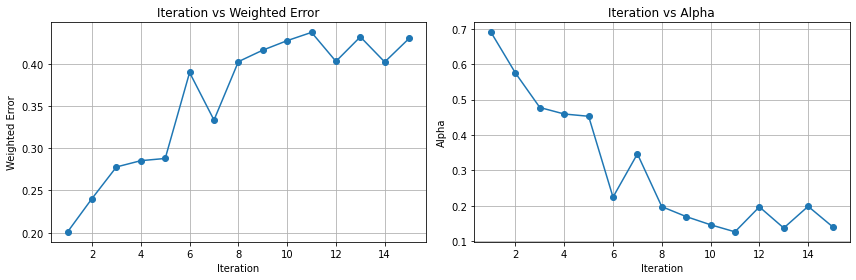


INTERPRETATION:
• AdaBoost increases weights on misclassified samples each round.
• Alpha grows when weighted error is small (strong learner).
• Manual AdaBoost improves accuracy compared to 1 stump.


In [11]:

# ----- Plots -----
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, T + 1), weighted_errors, marker='o')
plt.title("Iteration vs Weighted Error")
plt.xlabel("Iteration")
plt.ylabel("Weighted Error")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, T + 1), alphas, marker='o')
plt.title("Iteration vs Alpha")
plt.xlabel("Iteration")
plt.ylabel("Alpha")
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nINTERPRETATION:")
print("• AdaBoost increases weights on misclassified samples each round.")
print("• Alpha grows when weighted error is small (strong learner).")
print("• Manual AdaBoost improves accuracy compared to 1 stump.")

In [12]:
# ==========================================================
# PART D — Sklearn AdaBoost
# ==========================================================

print("\n==============================")
print(" PART D — sklearn AdaBoost")
print("==============================")

sk_ada = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=100,
    learning_rate=0.6,
    random_state=42
)

sk_ada.fit(X_train, y_train)

y_train_sk = sk_ada.predict(X_train)
y_test_sk = sk_ada.predict(X_test)

print("\nTrain accuracy:", accuracy_score(y_train, y_train_sk))
print("Test accuracy:", accuracy_score(y_test, y_test_sk))
print("\nConfusion Matrix (Test):\n", confusion_matrix(y_test, y_test_sk))
print("\nClassification Report:\n", classification_report(y_test, y_test_sk))

print("\n===== Comparison =====")
print(f"Manual AdaBoost (T=15)       Test Acc = {accuracy_score(y_test, y_test_manual):.4f}")
print(f"sklearn AdaBoost (100 trees) Test Acc = {accuracy_score(y_test, y_test_sk):.4f}")

# Feature importances
importances = sk_ada.feature_importances_
top_idx = np.argsort(importances)[-10:][::-1]

print("\nTop 10 Important Features (feature index : importance)")
for i in top_idx:
    print(f"{i} : {importances[i]:.6f}")


 PART D — sklearn AdaBoost

Train accuracy: 0.9619565217391305
Test accuracy: 0.9446254071661238

Confusion Matrix (Test):
 [[535  23]
 [ 28 335]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       558
           1       0.94      0.92      0.93       363

    accuracy                           0.94       921
   macro avg       0.94      0.94      0.94       921
weighted avg       0.94      0.94      0.94       921


===== Comparison =====
Manual AdaBoost (T=15)       Test Acc = 0.9023
sklearn AdaBoost (100 trees) Test Acc = 0.9446

Top 10 Important Features (feature index : importance)
45 : 0.060000
56 : 0.050000
51 : 0.050000
4 : 0.040000
44 : 0.040000
16 : 0.030000
22 : 0.030000
24 : 0.030000
25 : 0.030000
49 : 0.030000
